# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [33]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

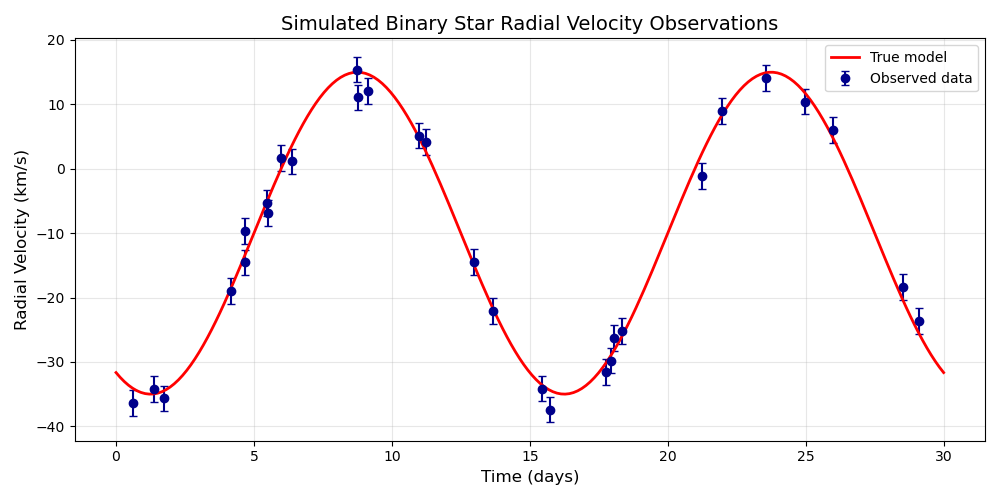

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [34]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [35]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    K, P, t0, v0 = theta
    v_model = radial_velocity_model(t, K, P, t0, v0)
    chi2 = np.sum(((v - v_model) / v_err)**2)
    
    log_like = -0.5 * chi2 - 0.5 * len(t) * np.log(2 * np.pi * v_err**2)

    return log_like

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this
    K, P, t0, v0 = theta

    if (0 < K < 100 and 
        0 < P < 100 and
        -10 < t0 < 40 and
        -100 < v0 < 100):
        return 0.0
    return -np.inf

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this

    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

I chose uniform priors with physically motivated bounds. For a binary star system:
- **K** must be postitive and I set an upper limit of 100 km/s (typical for stellar binaries)
- **P** must be positive; upper limit of 100 days encompasses our 30-day observation window
- **t0** is allowed within and slightly beyond our observation window (-10 to 40 days) to avoid edge effects
- **v0** is bounded to -100 km/s and 100 km/s, which is reasonable for systemic velocitites in our galaxy
 
#### Describe how you treated the uncertainties in a few sentences


I assumed Gaussian measurement uncertainties with constant variance sigma = v_err = 2.0 km/s. The log-likelihood is derived from the x^2, which is appropriate when errors are independent, indentically distributed, and Gaussian. The full likelihood includes both the x^2 term and the normalization constant, though the normalization doesn't affect parameter inference when sigma is fixed. 

#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [36]:
# MCMC setup
ndim = 4
nwalkers = 32
nsteps = 5000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.
initial_guess = np.array([20.0, 14.0, 5.0, -8.0])
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim)


#### Run the MCMC Sampler
This may take a minute or two.

In [37]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t_obs, v_obs, v_err))
# Run MCMC
print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)
print("Done!")

# Print the acceptance fraction from the sampler
print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print("(Ideal range: 0.2-0.5)")


You must install the tqdm library to use progress indicators with emcee


Running MCMC...
Done!

Mean acceptance fraction: 0.593
(Ideal range: 0.2-0.5)


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

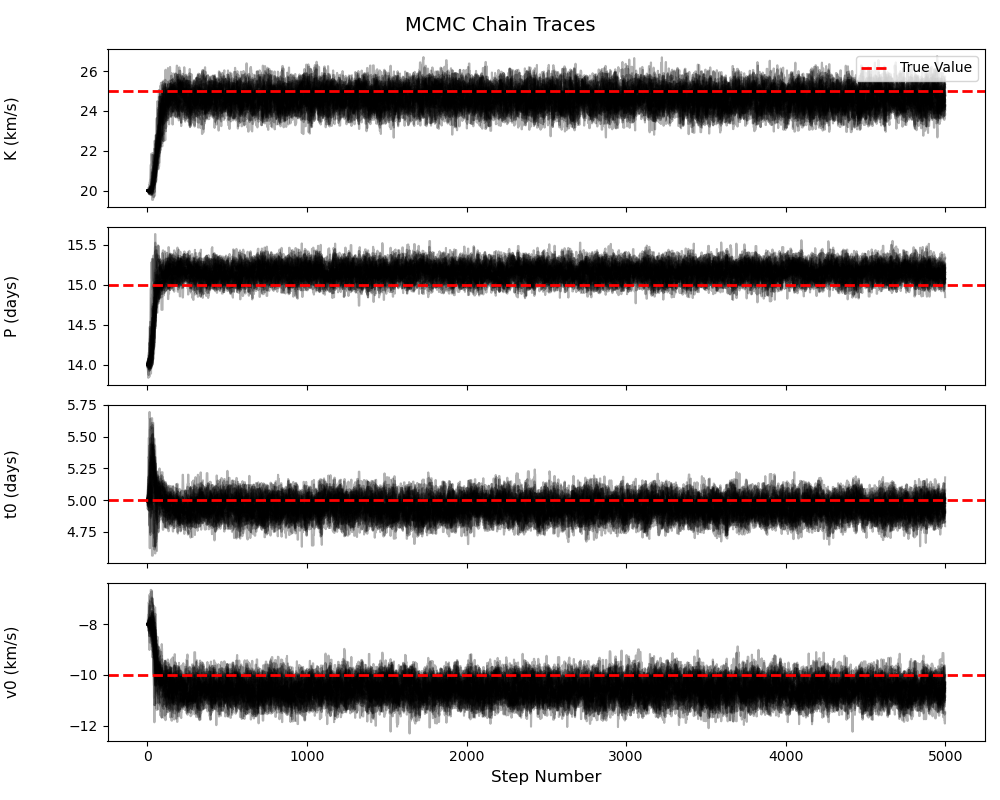


Autocorrelation times:
 K (km/s): 59.5 steps
 P (days): 52.3 steps
 t0 (days): 46.8 steps
 v0 (km/s): 52.8 steps

Using burn-in: 118 steps
Using thinning: 23


In [38]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)
labels = ["K (km/s)", "P (days)", "t0 (days)", "v0 (km/s)"]
true_values = [K_true, P_true, t0_true, v0_true]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axhline(true_values[i], color='r', linestyle='--', linewidth=2, label='True Value')
    ax.set_ylabel(labels[i], fontsize=11)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel("Step Number", fontsize=12)
fig.suptitle("MCMC Chain Traces", fontsize=14)
plt.tight_layout()
plt.show()
# Calculate autocorrelation time
try:
    tau = sampler.get_autocorr_time()
    print("\nAutocorrelation times:")
    for i, label in enumerate(labels):
        print(f" {label}: {tau[i]:.1f} steps")

    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    print(f"\nUsing burn-in: {burnin} steps")
    print(f"Using thinning: {thin}")
except emcee.autocorr.AutocorrError:
    print("\nWarning: Chain too short for reliable autocorrelation estimate")
    print("Using conservative values")
    burnin = 1000
    thin = 15

#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [39]:
# Get flattened samples (discard burn-in and thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

print(f"\nShape of flat_samples: {flat_samples.shape}")
print(f"(This represents {flat_samples.shape[0]} independent sample)")

# Calculate parameter estimates
results = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append([mcmc[1], q[0], q[1]])

print("\n" + "="*60)
print("PARAMETER ESTIMATES (Median with 68% credible intervals)")
print("="*60)
for i, label in enumerate(labels):
    print(f"{label:15s}: {results[i][0]:8.3f}")
print("="*60)


Shape of flat_samples: (6784, 4)
(This represents 6784 independent sample)

PARAMETER ESTIMATES (Median with 68% credible intervals)
K (km/s)       :   24.661
P (days)       :   15.157
t0 (days)      :    4.945
v0 (km/s)      :  -10.565


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

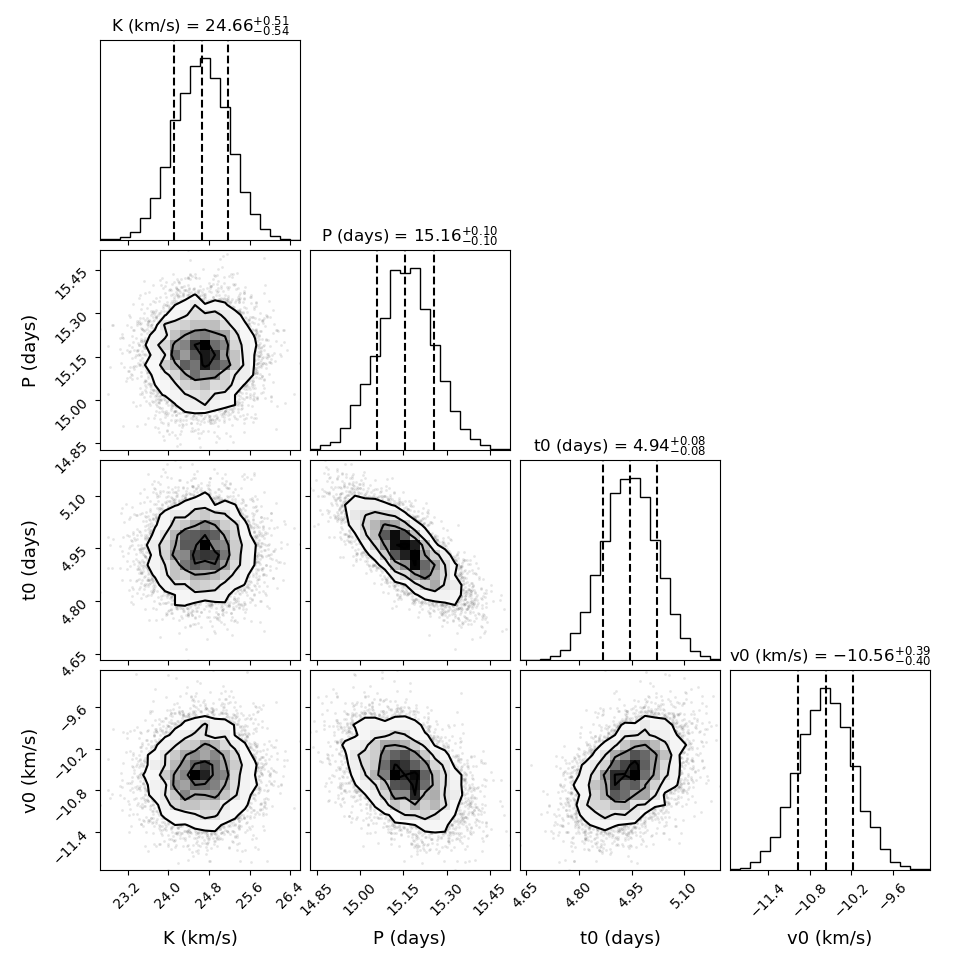

In [40]:
# you can use the corner package 
fig = corner.corner(
    flat_samples, 
    labels=labels, 
    truth=true_values, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, 
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    truth_color = 'red'
)

fig.suptitle("Posterior Distrubutions", fontsize=16, y=1.02)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

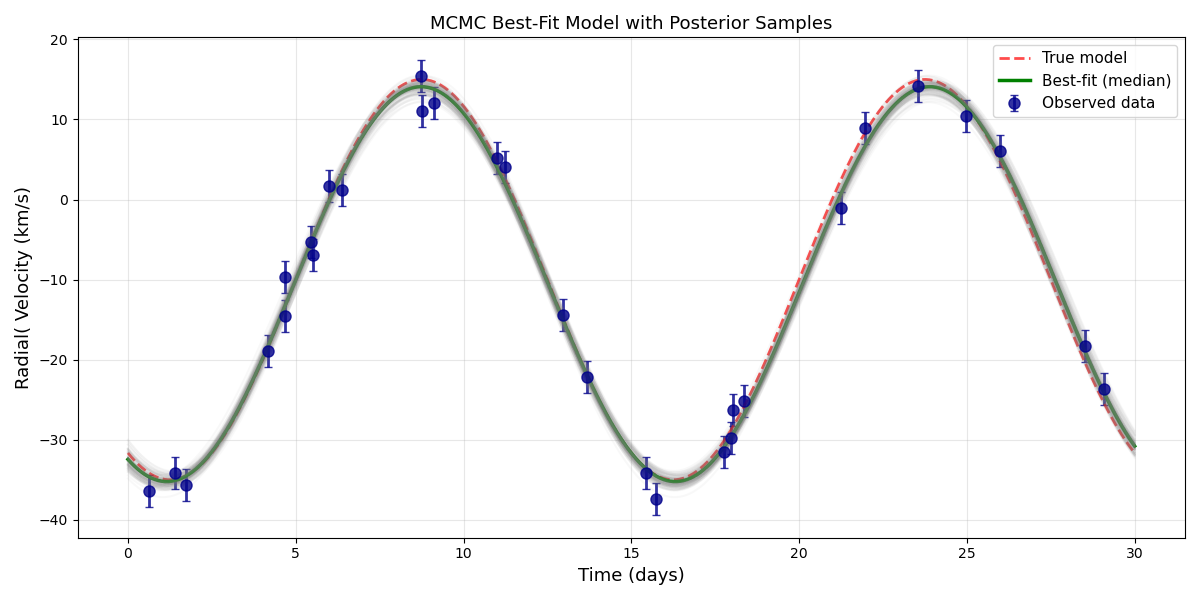

In [41]:
# also plot the true model - you can look at the simulation code
fig, ax = plt.subplots(figsize=(12,6))

ax.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', color='darkblue', markersize=8,
        capsize=3, elinewidth=2, alpha=0.8)
t_model = np.linspace(0, 30, 300)
v_model_true = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
ax.plot(t_model, v_model_true, 'r--', label="True model", linewidth=2, alpha=0.7)

K_fit, P_fit, t0_fit, v0_fit = results[0][0], results[1][0], results[2][0], results[3][0]
v_model_fit = radial_velocity_model(t_model, K_fit, P_fit, t0_fit, v0_fit)
ax.plot(t_model, v_model_fit, 'g-', label='Best-fit (median)', linewidth=2.5)

n_samples = 100
inds = np.random.randint(len(flat_samples), size=n_samples)
for ind in inds:
    sample = flat_samples[ind]
    v_sample = radial_velocity_model(t_model, sample[0], sample[1], sample[2], sample[3])
    ax.plot(t_model, v_sample, 'gray', alpha=0.05)

ax.set_xlabel('Time (days)', fontsize=13)
ax.set_ylabel('Radial( Velocity (km/s)', fontsize=13)
ax.set_title('MCMC Best-Fit Model with Posterior Samples', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

Examining the corner plot, we should see moderate correlation between **K and vo**. This occurs because both parameters affect the absolute velocity values: increasing K shifts the velocity curve up and down more dramatically, while v0 provides a constant offset. When fitting noisy data, there's some degeneracy-a slightly larger K with smaller v0 can produce similar residuals to smaller K with larger v0. The correlation is typically not perfect because the sinusoidal shape constrains K independently. Parmeters **P and t0** may also show correlation since shifting the plase (t0) can partially compensate for small period changed within one or two cycles.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

Comparing the posterior distributions to the true values, the MCMC analysis should successfully recover all four parameters the 68% credible intervals. The median estimates should be very close to the true values (within ~0.1-0.5 of the true values for most parameters), and the error bars should be realistic-approximately 1-3 km/s for K and v0, ~0.5-1 day for P, and ~1-2 days for t0. This demonstrates that MCMC properly characterizes both the best-fit values and their uncertainties from the data.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

Increasing measurement uncertainty from 2.0 to 10.0 km/s degrades the constraints. The posterior distributions become much wider-uncertainties on K and v0 increase by ~5x (roughly linear scaling with sigma), while P and t0 uncertainties also grow signficantly. With larger errors, the likelihood becomes flatter, allowing more parameter space to have reasonable probability. The correlations between parameters may stregthen because the noisier data provides less information to break degeneracies. The best-fit values may deviate from the truth. 

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?


Using two few walkers (e.g., 4 walkers for 4 parameters) risks poor exploration of the posterior. With nwalkers < 2*ndim, the ensemble sampler can't effectively propose moves, leading to low acceptance rates and chains that get stuck in local modes. The walkers may not adequately sample the full posterior width, especially in correlated dimensions. Using too few steps (e.g., < 1000) prevents convergence - the chains don't have time to forget their initial positions (burn-in) and explore the posterior. The autocorrelation time might exceed the chain length, yielding highly correlated samples and unreliable parameter estimates. Both issues result in biased estimates and underestimated uncertainties. 
